## MODELING

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix  
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import auc, multilabel_confusion_matrix, plot_roc_curve

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

%matplotlib inline

In [27]:
#importing data
clean_data= pd.read_csv('Data/cleaned_water_pump.csv')
clean_data.head()

,status_group,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,age_at_inspection,unknown_construction_year
0,functional,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,55.045872,12.0,False
1,functional,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.000000,3.0,False
2,functional,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,...,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0.100000,4.0,False
3,non functional,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0.000000,27.0,False
4,functional,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.000000,NaN,False


In [28]:
#changing region_code to str
clean_data['region_code'] = clean_data['region_code'].astype('str')

In [29]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status_group               59400 non-null  object 
 1   amount_tsh                 59400 non-null  float64
 2   gps_height                 59400 non-null  int64  
 3   basin                      59400 non-null  object 
 4   region                     59400 non-null  object 
 5   region_code                59400 non-null  object 
 6   lga                        59400 non-null  object 
 7   public_meeting             59400 non-null  object 
 8   scheme_management          59400 non-null  object 
 9   permit                     59400 non-null  object 
 10  extraction_type_group      59400 non-null  object 
 11  extraction_type_class      59400 non-null  object 
 12  management                 59400 non-null  object 
 13  management_group           59400 non-null  obj

In [30]:
#checking target variables
clean_data['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [31]:
# The target variables have to be encoded
le = LabelEncoder()
clean_data["status_group"] = le.fit_transform(clean_data["status_group"])

In [32]:
# Each class has been assigned new numerical values; 0 - functional, 2 - nonfunctional, 1 - functional needs repair
clean_data['status_group'].value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
Name: status_group, dtype: float64

## Setting up pipeline and functions

In this section the Standard scaler and minmaxScaler are used as the pipelines. Standard scaler is used in the Baseline, Desion Tree, 
Random Forest and Logistical models.

In [33]:
# Initiate Train Test Split
X = clean_data.drop('status_group', axis=1)
y = clean_data['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
#Setting up Data for encoding within both Pipelines
numeric_cols = ["amount_tsh", "gps_height", "age_at_inspection", "water_per_person"]

cat_cols =["basin", "region", "region_code", "lga", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]
bool_cols = ["unknown_construction_year"]

In [35]:
# Create subpipelines for Standard Scaler having the mean for the imputer, for the numerical and categorical. This bit is for converting categorical variables into numerical format using techniques like One-Hot Encoding.

# Numerical encoder
subpipe_num = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("ss", StandardScaler())])

# Categorical encoder
subpipe_cat = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])

#Ordinal encoder
subpipe_ord = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [36]:
# Create subpipelines for MinMaxScaler for the  KNN Model, for the numerical and categorical data

# Numerical encoder
subpipe_num2 = Pipeline(steps=[("num_impute", SimpleImputer(strategy="median")),("mm", MinMaxScaler())])

# Categorical encoder
subpipe_cat2 = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])

# Ordinal encoder
subpipe_ord2 = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [37]:
# Include our sub pipelines in a column transformer to OHE our categorial variables and scale our numerical variables. (Standard Scaler)
CT = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat, cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

In [38]:
 # Include our sub pipelines in a column transformer to OHE our categorial variables and scale our numerical variables. (MinMaxScaler)
CT2 = ColumnTransformer(transformers=[
                                    ("subpipe_num2", subpipe_num2, numeric_cols), 
                                     ("subpipe_cat2", subpipe_cat2, cat_cols),
                                    ("subpipe_ord2", subpipe_ord2, bool_cols)
                                    ], 
                       remainder="drop"
                      )

## MODELS

We beign with creating the Baseline model then Logistical, KNN, Decision Tree and lastly Random Forest models.
Evaluation of the models will be done using the Accuracy and Precision metrics. All models will be compared to the Baseline model.


####  Model 1- Baseline Model (Dummy Model)

In [39]:
# Instantiate the dummy regressor object
dummy_model_pipe = Pipeline(steps=[('ct', CT), ('dum', 
                                                DummyClassifier(strategy="most_frequent",random_state=42))])

In [40]:
# Fit the model on our training data
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [41]:
# Inspect the accuracy of the dummy model
dummy_model_pipe.score(X_train, y_train)

0.542334455667789

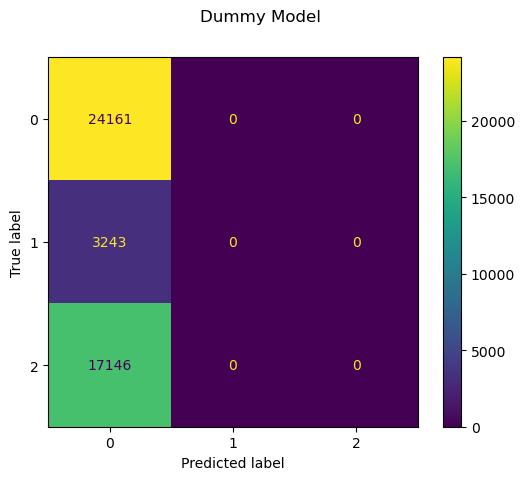

In [42]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

#Plot confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, ax =ax);

In [43]:
dummy_y_pred = dummy_model_pipe.predict(X_test)

In [44]:
print(classification_report(y_test, dummy_y_pred));

c:\Users\Bee\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       0.00      0.00      0.00      1074
           2       0.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.18      0.33      0.24     14850
weighted avg       0.30      0.55      0.38     14850



In [45]:
confusion_matrix(y_test, dummy_y_pred)

array([[8098,    0,    0],
       [1074,    0,    0],
       [5678,    0,    0]], dtype=int64)

####  Model 2 - Logistic Regression Model 

In [46]:
log_model_pipe = Pipeline(steps=[('ct', CT), 
                                    ('log', LogisticRegression(random_state=42, max_iter=1000))])

In [47]:
log_model_pipe.fit(X_train, y_train)
log_model_pipe.score(X_train, y_train)

0.7510662177328844

In [48]:
log_y_pred = log_model_pipe.predict(X_test)
print(classification_report(y_test, log_y_pred));

              precision    recall  f1-score   support

           0       0.74      0.89      0.80      8098
           1       0.51      0.12      0.20      1074
           2       0.78      0.66      0.72      5678

    accuracy                           0.75     14850
   macro avg       0.67      0.56      0.57     14850
weighted avg       0.74      0.75      0.73     14850



####  Model 3 - K Nearest Neighbors Model 

In [49]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=5, weights='distance'))])

In [50]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [51]:
knneighbors_model_pipe.score(X_train, y_train)

0.9350392817059484

In [52]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)
print(classification_report(y_test, knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      8098
           1       0.41      0.38      0.40      1074
           2       0.79      0.74      0.76      5678

    accuracy                           0.76     14850
   macro avg       0.66      0.65      0.66     14850
weighted avg       0.76      0.76      0.76     14850



####  Model 4 - Decision Tree Model 

In [53]:
dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
    criterion='entropy'))])

In [54]:
dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [55]:
dct_model_pipe.score(X_train, y_train)

0.9418406285072952

In [56]:
dct_y_pred = dct_model_pipe.predict(X_test)
print(classification_report(y_test, dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      8098
           1       0.38      0.36      0.37      1074
           2       0.77      0.73      0.75      5678

    accuracy                           0.75     14850
   macro avg       0.64      0.64      0.64     14850
weighted avg       0.75      0.75      0.75     14850



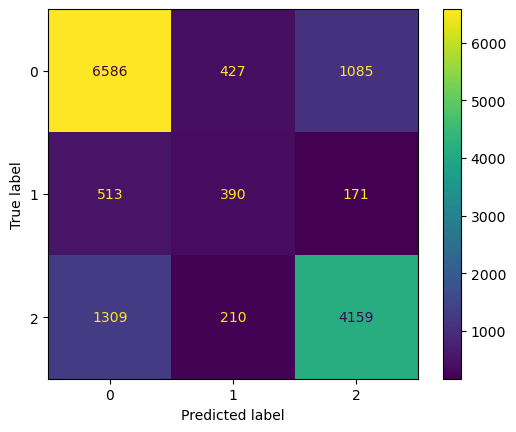

In [57]:
plot_confusion_matrix(estimator=dct_model_pipe, X=X_test, y_true=y_test);

####  Model 5 - Random Forest Model 

In [58]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [59]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [60]:
rfc_model_pipe.score(X_train, y_train)

0.9418181818181818

In [61]:
rfc_y_preds = rfc_model_pipe.predict(X_test)

print(classification_report(y_test, rfc_y_preds))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8098
           1       0.46      0.36      0.40      1074
           2       0.81      0.75      0.78      5678

    accuracy                           0.78     14850
   macro avg       0.69      0.66      0.67     14850
weighted avg       0.78      0.78      0.78     14850



### Comparison of First 5 Models

### WORDS

<img src='images/Model_Results1.png' width=100%/>

## GridSearch and Model Optimization
We decided that the Logistical Model didnt do much better than our Dummy Model. While precison was high for our repair pump class - the recall was very low. The f1 score was the lowest - so we turned our attention to our other models. We feel that we can get better metrics. So we decided to run several GridSearches to find the optimal hyperparameters for our KNN, Decision Tree, and RandomForest Models. 

####  Model 6 - Optimized KNN Model 

In [62]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier())])

In [63]:
knn_pipe_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], 
    'knn__metric': ['minkowski', 'manhattan', 'euclidean'],
    'knn__weights': ['uniform', 'distance']

}


knn_gs_pipe = GridSearchCV(estimator=knneighbors_model_pipe, param_grid=knn_pipe_grid)

<img src='images/KNN_Gridsearch.png' width=100%/>

In [64]:
optimal_knneighbors_model_pipe = Pipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
              metric='manhattan', n_neighbors=17, weights='distance'))])

In [65]:
optimal_knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [66]:
optimal_knneighbors_model_pipe.score(X_train, y_train)

0.9412121212121212

In [67]:
opt_knn_y_preds = optimal_knneighbors_model_pipe.predict(X_test)

print(classification_report(y_test, opt_knn_y_preds))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8098
           1       0.47      0.35      0.40      1074
           2       0.80      0.74      0.77      5678

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



####  Model 7 - Optimized Decision Tree Model 

In [68]:
dct_model_pipe = Pipeline(steps=[('ct', CT), ('dct', DecisionTreeClassifier(random_state=42))])

In [70]:
pipe_grid_dt = {
    'dt__criterion': ['gini', 'entropy', 'log_loss'], 
    'dt__class_weight': ['None', 'balanced'],
    'dt__min_impurity_decrease': [0.15, 0.2, 0.3]

}


gs_pipe_dt = GridSearchCV(estimator=dct_model_pipe, param_grid=pipe_grid_dt)

<img src='\images\DCT_Gridsearch.png' width=100%/>

In [ ]:
optimal_dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
                            criterion='gini',class_weight=None, min_impurity_decrease=0.15))])

In [ ]:
optimal_dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
optimal_dct_model_pipe.score(X_train, y_train)

0.542334455667789

In [ ]:
opt_dct_y_pred = optimal_dct_model_pipe.predict(X_test)
print(classification_report(y_test, opt_dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       1.00      0.00      0.00      1074
           2       1.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.38     14850



####  Model 8 - Optimized Random Forest Model 

In [ ]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
pipe_grid_rfc = { 
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_samples_leaf': [5, 10, 30],
    'rfc__n_estimators': [50, 100, 150],
}

gs_pipe_rfc = GridSearchCV(estimator = rfc_model_pipe, param_grid=pipe_grid_rfc)

<img src='images/RFC_Gridsearch1.png' width=100%/>

In [ ]:
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42, 
                                criterion='gini', min_samples_leaf=5, n_estimators=100))])

In [ ]:
optimal_rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
optimal_rfc_model_pipe.score(X_train, y_train)

0.8051851851851852

In [ ]:
opt_rfc_y_pred = optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, opt_rfc_y_pred));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8098
           1       0.65      0.19      0.29      1074
           2       0.84      0.70      0.76      5678

    accuracy                           0.78     14850
   macro avg       0.75      0.60      0.63     14850
weighted avg       0.78      0.78      0.77     14850



#### Optimal Model Comparisons

<img src='images/Optimal_Model_Results.png' width=100%/>

## Model Analysis

Taking a look at our results - between our optimal KNN and Random Forest Models - we have pretty good scores on predicting which pumps are nonfunctional or functional (precision scores of 79% - KNN, and 81%(nonfunctional) and 80%(functional) for RFC.  

Our models dont have a really high precison score in our class (1) of interest - so when we predict a pump is in need of repair - we are only accurate 47%(KNN) or 65% (RFC) of the time. We also see that recall scores for our target class is pretty bad - meaning both models arent doing a great job at finding the pumps that are in need of repair - our KNN model is 35% which is better than the Random Forest model's recall score of 19%.

Overall our models arent doing a great job when it comes to predicting pumps in need of repair. We arent giving it enough information. This is probably due to the class imbalance we see in our target. only 7% of pumps are in need of repair compared to 54% (functioning) and 39%(nonfuctioning). Our next step is do try smoting the data to increase this minority class.


## Using Smote


We realized that all our previous models had some trouble making predictions in our target class of interest - 1 ie the pumps in need of repair. We decided to use 3 different smote techniques and apply them to our two best performing models - the RandomForest and the KNN. We first tried over sampling the Minority class and undersampling the Majority Classes, then we just over sampled the Minority class, finally we tried doubling the minoriry class while keeping all the functional and nonfunctional numbers the same.

In [ ]:
# Check the class distribution of the target
counter = Counter(y_train)
print(counter)

Counter({0: 24161, 2: 17146, 1: 3243})


In [ ]:
# Create the oversampler and undersampler objects
over = SMOTE(sampling_strategy="minority", random_state=42)
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

## Model 9 - Smote Model  
Random Forest with oversamping Minority and undersampling Majority Classes

In [ ]:
rfc_sm1_pipe = ImbPipeline(steps=[('ct', CT), ("over", over), ("under", under), 
                             ('rfc', RandomForestClassifier(random_state=42, 
                                criterion='gini', min_samples_split=6, n_estimators=150))])

In [ ]:
rfc_sm1_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
rfc_sm1_pipe.score(X_train, y_train)

0.8595735129068462

In [ ]:
rfc_sm1_y_pred = rfc_sm1_pipe.predict(X_test)
print(classification_report(y_test, rfc_sm1_y_pred));

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      8098
           1       0.32      0.54      0.40      1074
           2       0.78      0.77      0.78      5678

    accuracy                           0.75     14850
   macro avg       0.64      0.69      0.66     14850
weighted avg       0.77      0.75      0.76     14850



## Model 10 - Smote Model  
KNN with oversamping Minority and undersampling Majority Classes

In [ ]:
knn_sm1_pipe = ImbPipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
              metric='manhattan', n_neighbors=17, weights='distance'))])

In [ ]:
knn_sm1_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [ ]:
knn_sm1_pipe.score(X_train, y_train)

0.9412121212121212

In [ ]:
knn_sm1_y_pred = knn_sm1_pipe.predict(X_test)
print(classification_report(y_test, knn_sm1_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8098
           1       0.47      0.35      0.40      1074
           2       0.80      0.74      0.77      5678

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



## Model 11 - Smote Model  
Random Forest with oversamping Minority

In [ ]:
rfc_sm2_pipe = ImbPipeline(steps=[('ct', CT), ("over", over), ('rfc', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])

In [ ]:
rfc_sm2_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
rfc_sm2_pipe.score(X_train, y_train)

0.8786307519640852

In [ ]:
rfc_sm2_y_pred = rfc_sm2_pipe.predict(X_test)
print(classification_report(y_test, rfc_sm2_y_pred ));

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      8098
           1       0.32      0.53      0.40      1074
           2       0.83      0.73      0.78      5678

    accuracy                           0.76     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.78      0.76      0.77     14850



## Model 12 - Smote Model  
KNN with oversamping Minority

In [ ]:
knn_sm2_pipe = ImbPipeline(steps=[('ct', CT2), ('knn', KNeighborsClassifier(
              metric='manhattan', n_neighbors=17, weights='distance'))])

In [ ]:
knn_sm2_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [ ]:
knn_sm2_pipe.score(X_train, y_train)

0.9412121212121212

In [ ]:
knn_sm2_y_pred = knn_sm2_pipe.predict(X_test)
print(classification_report(y_test, knn_sm2_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8098
           1       0.47      0.35      0.40      1074
           2       0.80      0.74      0.77      5678

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



## Model 13 - Smote Model  
Random Forest with doubling of the minority class

In [ ]:
counter1 = Counter(y_train)
print(counter1)

Counter({0: 24161, 2: 17146, 1: 3243})


In [ ]:
strategy = {0:24161, 2:17146, 1:6486}
over = SMOTE(sampling_strategy=strategy, random_state=42)

In [ ]:
rfc_sm3_pipe = ImbPipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier
                                (criterion= "gini", min_samples_split=6, 
                                 n_estimators=150, random_state=42))])


In [ ]:
rfc_sm3_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
rfc_sm3_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
rfc_sm3_y_pred = rfc_sm3_pipe.predict(X_test)
print(classification_report(y_test, rfc_sm3_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      8098
           1       0.53      0.31      0.39      1074
           2       0.82      0.75      0.78      5678

    accuracy                           0.79     14850
   macro avg       0.71      0.65      0.67     14850
weighted avg       0.78      0.79      0.78     14850



## Model 14 - Smote Model  
KNN with doubling of the minority class

In [ ]:
knn_sm3_pipe = ImbPipeline(steps=[('ct', CT2), ("over", over), 
                ('knn', KNeighborsClassifier(metric='manhattan', 
                n_neighbors=17, weights='distance'))])


In [ ]:
knn_sm3_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num2',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),


In [ ]:
knn_sm3_pipe.score(X_train, y_train)

0.9411447811447812

In [ ]:
knn_sm3_y_pred = knn_sm3_pipe.predict(X_test)
print(classification_report(y_test, knn_sm3_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8098
           1       0.43      0.38      0.40      1074
           2       0.80      0.73      0.76      5678

    accuracy                           0.77     14850
   macro avg       0.67      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



<img src='images/Smote_Model_Results.png' width=100%/>

## Final Model  
Overall when comparing precision scores our best performing model was actually our optimal Random Forest Model.
The accuracy of this model was lower than the individual trees at 0.80, however, our precision was the highest of all of our models at .65 — meaning that 65% of the time our model predicts a water pump in need of repair, the water pump does need a repair. 

In [ ]:
#reloading our optimal Random Forest Model from above
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42, 
                                criterion='gini', min_samples_leaf=5, n_estimators=100))])

In [ ]:
optimal_rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
optimal_rfc_model_pipe.score(X_train, y_train)

0.8051851851851852

In [ ]:
opt_rfc_y_pred = optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, opt_rfc_y_pred));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8098
           1       0.65      0.19      0.29      1074
           2       0.84      0.70      0.76      5678

    accuracy                           0.78     14850
   macro avg       0.75      0.60      0.63     14850
weighted avg       0.78      0.78      0.77     14850



In [ ]:
#getting feature importance
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"]

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"]

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
cat_features_list = list(optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"].get_feature_names())

In [ ]:
X_train.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
24947,20.0,330,Wami / Ruvu,Pwani,6,Bagamoyo,True,VWC,True,submersible,...,user-group,pay per bucket,salty,insufficient,machine dbh,groundwater,communal standpipe,0.25,False,39.0
22630,0.0,0,Lake Victoria,Mwanza,17,Magu,Unknown,WUG,False,nira/tanira,...,user-group,unknown,good,enough,shallow well,groundwater,hand pump,NaN,True,NaN
13789,0.0,0,Lake Victoria,Mwanza,19,Kwimba,True,VWC,True,india mark ii,...,user-group,never pay,good,enough,machine dbh,groundwater,hand pump,NaN,True,NaN
15697,0.0,1542,Internal,Singida,13,Singida Urban,True,WUA,True,gravity,...,user-group,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.00,False,3.0
22613,0.0,523,Lake Nyasa,Ruvuma,10,Mbinga,Unknown,VWC,True,gravity,...,user-group,unknown,good,dry,spring,groundwater,communal standpipe,0.00,False,0.0


In [ ]:
features_names = ["amount_tsh", "gps_height"] + cat_features_list + ["water_per_person", "unknown_construction_yr", "age_at_inspection"]

In [ ]:
rfc_importances = optimal_rfc_model_pipe.named_steps["rfc"].feature_importances_

In [ ]:
#creating a dictionary of feature importance
optimal_rfc_model_feature_importance_dict = dict(zip(features_names, rfc_importances)) 

In [ ]:
sort_feature_importance = sorted(optimal_rfc_model_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in sort_feature_importance:
    print(i[0], i[1])

x13_insufficient 0.14027828804465312
x0_Internal 0.057160681954456206
unknown_construction_yr 0.04565125216095784
x13_seasonal 0.041893955617869655
gps_height 0.037568398243498974
x8_submersible 0.0371984312324623
x7_other motorpump 0.03528754611593883
amount_tsh 0.030390615163535174
x0_Lake Nyasa 0.02677327859923114
x16_dam 0.017414148876290045
x13_unknown 0.016381528557518357
x11_pay annually 0.015892779924744246
x13_enough 0.013844224234665217
x8_other 0.012956781291852182
x7_india mark iii 0.012157186023959442
x16_hand pump 0.011442730226705191
x16_other 0.010415392092595913
x9_water board 0.008819699641442094
x15_groundwater 0.008808281986173505
x7_other handpump 0.008114562655105274
x11_unknown 0.007777268572419805
x2_13 0.007407089676433712
x14_unknown 0.007256007476073383
x8_motorpump 0.007056124127864869
x5_WUG 0.0068832860344387415
x7_afridev 0.006827096711604138
x1_Kigoma 0.006564751061853383
x6_Unknown 0.0063321936871662465
x16_cattle trough 0.006209891029728323
x15_unknown

We took this model and ran feature_importances to find the best predictors of the class in this most precise model and found these three features had some of the highest predictors of classification within the model: 
* Whether or not the pump is in the Internal Drainage Basin
* Age of pump at inspection (a feature that we engineered using construction year and recorded date)
* Gps_height or the altitude of the pump. 
* Whether the quantity of the well was insufficient or not. 

## Feature Importance Visuals

In [ ]:
#renaming status group columns by importing data again
rename_df = pd.read_csv('Data/cleaned_water_pump.csv')
rename_df.head()

,status_group,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
0,functional,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,55.045872,False,12.0
1,functional,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.000000,False,3.0
2,functional,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,...,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0.100000,False,4.0
3,non functional,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0.000000,False,27.0
4,functional,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,NaN,True,NaN


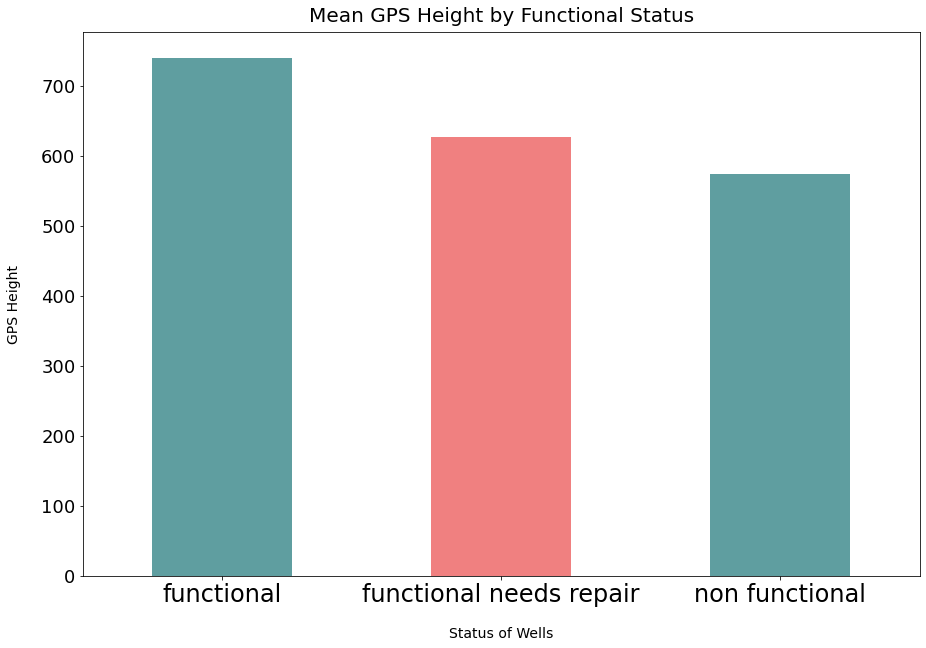

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

ax = rename_df["gps_height"].groupby(by=rename_df["status_group"]).mean().plot(kind='bar', color = ["cadetblue", "lightcoral", "cadetblue"]);
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title('Mean GPS Height by Functional Status', fontsize='20', pad=10)
ax.set_xlabel('Status of Wells', fontsize='14', labelpad=20)
ax.set_ylabel('GPS Height', fontsize='14', labelpad=20)
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=18)


plt.xticks(rotation=0);


plt.savefig('./images/GPS_v_Status_bar_Chart', bbox_inches="tight", dpi=500);

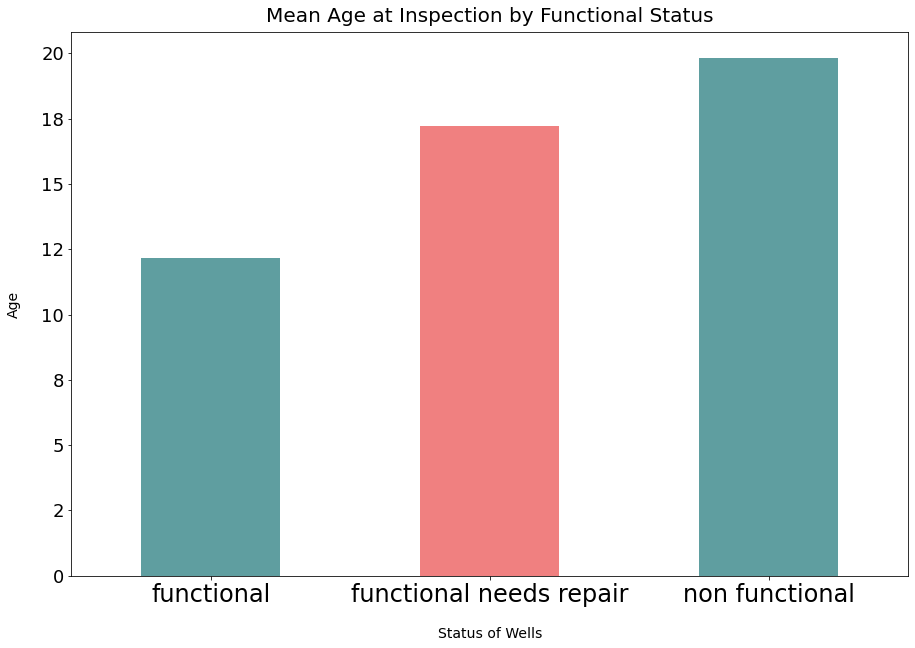

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

ax = rename_df["age_at_inspection"].groupby(by=rename_df["status_group"]).mean().plot(kind='bar', color = ["cadetblue", "lightcoral", "cadetblue"]);
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title('Mean Age at Inspection by Functional Status', fontsize='20', pad=10)
ax.set_xlabel('Status of Wells', fontsize='14', labelpad=20)
ax.set_ylabel('Age', fontsize='14', labelpad=20)
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=18)


plt.xticks(rotation=0);


plt.savefig('./images/Mean_inspection_age_v_Status_bar_Chart', bbox_inches="tight", dpi=500);

## Evaluating our  test sample
To evaluate our test data we will transform the test data using the same pipeline as our optimal Random Forest Model. This allows it to encode our columns the same way as our training data.
Then we'll take a look at our accuracy and precision scores along with recall and the f1 score of both models.

In [ ]:
test_optimal_rfc_model_pipe = optimal_rfc_model_pipe

In [ ]:
test_optimal_rfc_model_pipe.score(X_test, y_test)

0.7822895622895623

In [ ]:
test_opt_rfc_y_pred = test_optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, test_opt_rfc_y_pred));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8098
           1       0.65      0.19      0.29      1074
           2       0.84      0.70      0.76      5678

    accuracy                           0.78     14850
   macro avg       0.75      0.60      0.63     14850
weighted avg       0.78      0.78      0.77     14850



 #### Overall it does seem like our model performed similarly on both the test and train data. We can accurately predict the target class - pumps in need of repair 65% of the time.